In [ ]:
import math
import itertools
from random import randrange
import time
from random import shuffle
from builtins import range
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


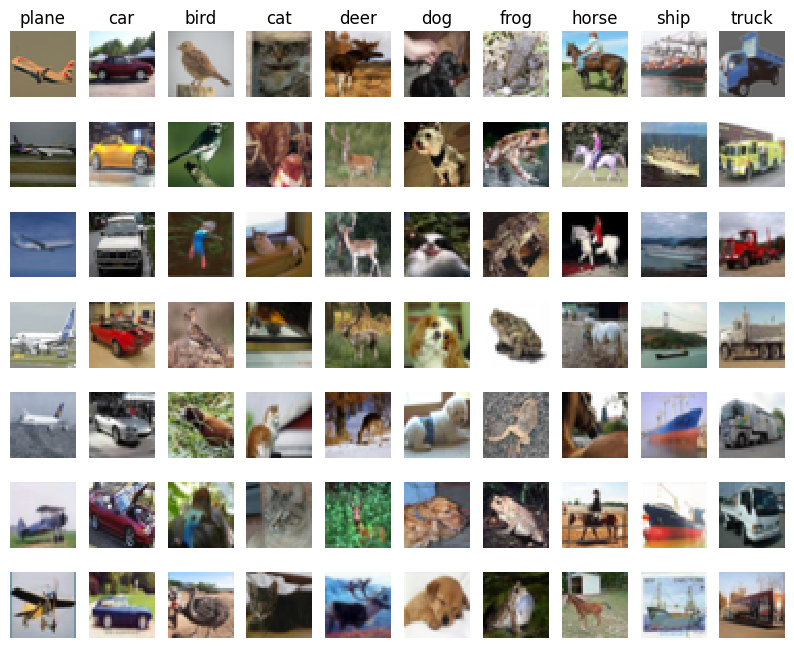

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/content'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


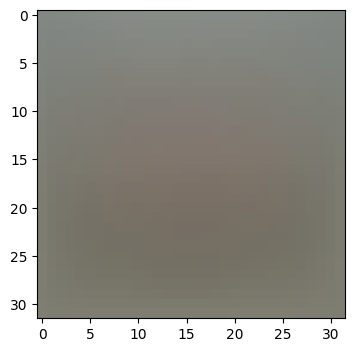

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])  # print a few of the elements
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype(
    'uint8'))  # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [ ]:
def svm_loss_naive(W, X, y, reg):
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]    # update gradient for incorrect label
                dW[:, y[i]] -= X[i]  # update gradient for correct label
    loss /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)
    dW /= num_train   # scale gradient ovr the number of samples
    dW += 2 * reg * W  # append partial derivative of regularization term

    return loss, dW


def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    N = len(y)     # number of samples
    Y_hat = X @ W  # raw scores matrix

    y_hat_true = Y_hat[range(N), y][:, np.newaxis]    # scores for true labels
    margins = np.maximum(0, Y_hat - y_hat_true + 1)   # margin for each score
    loss = margins.sum() / N - 1 + reg * np.sum(W**2)  # regularized loss

    dW = (margins > 0).astype(int)    # initial gradient with respect to Y_hat
    # update gradient to include correct labels
    dW[range(N), y] -= dW.sum(axis=1)
    dW = X.T @ dW / N + 2 * reg * W   # gradient with respect to W

    return loss, dW



In [ ]:

# Evaluate the naive implementation of the loss we provided for you:
# from cs231n.classifiers.linear_svm import svm_loss_naive

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

s = np.sum(np.array([2, 1, 2, 3, 4, 5]) <= 3)
print(np.array([2, 1, 2, 3, 4, 5]) <= 3)

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

[ True  True  True  True False False]
loss: 9.147901


In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evaluate f(x + h)
        x[ix] = oldval - h  # increment by h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / \
            (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' %
              (grad_numerical, grad_analytic, rel_error))


In [ ]:
# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
# from cs231n.gradient_check import grad_check_sparse


def f(w): return svm_loss_naive(w, X_dev, y_dev, 0.0)[0]


grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
def f(w): return svm_loss_naive(w, X_dev, y_dev, 1e2)[0]


grad_numerical = grad_check_sparse(f, W, grad)

numerical: -5.536400 analytic: -5.536400, relative error: 8.239362e-12
numerical: -5.900722 analytic: -5.900722, relative error: 2.519762e-11
numerical: 35.015002 analytic: 35.015002, relative error: 4.362892e-15
numerical: -4.596761 analytic: -4.596761, relative error: 1.259011e-11
numerical: -4.558389 analytic: -4.558389, relative error: 8.416603e-11
numerical: -15.613803 analytic: -15.613803, relative error: 3.866054e-11
numerical: 7.819404 analytic: 7.810166, relative error: 5.910778e-04
numerical: 21.868772 analytic: 21.868772, relative error: 1.204571e-11
numerical: 13.712222 analytic: 13.712222, relative error: 2.912695e-11
numerical: -0.047195 analytic: -0.113765, relative error: 4.135850e-01
numerical: -12.804181 analytic: -12.804181, relative error: 1.589397e-11
numerical: 27.566771 analytic: 27.566771, relative error: 3.948137e-13
numerical: -46.251337 analytic: -46.251337, relative error: 8.816620e-12
numerical: 39.132679 analytic: 39.132679, relative error: 4.091560e-12
nu

In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00005)
toc = time.time()
print('Naive loss and gradient: computeh in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss: 9.147901e+00 computed in 0.105800s
Vectorized loss: 9.147901e+00 computed in 0.011448s
difference: -0.000000
Naive loss and gradient: computeh in 0.101680s
Vectorized loss and gradient: computed in 0.009426s
difference: 0.000000


In [ ]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        # assume y takes values 0...K-1 where K is number of classes
        num_classes = np.max(y) + 1
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            batch_indices = np.random.choice(
                num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -= learning_rate * grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: D x N array of training data. Each column is a D-dimensional point.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

iteration 0 / 1500: loss 1581.075304
iteration 100 / 1500: loss 213.723716
iteration 200 / 1500: loss 32.835789
iteration 300 / 1500: loss 9.194516
iteration 400 / 1500: loss 6.544874
iteration 500 / 1500: loss 6.002089
iteration 600 / 1500: loss 5.246578
iteration 700 / 1500: loss 5.937518
iteration 800 / 1500: loss 5.189203
iteration 900 / 1500: loss 5.117195
iteration 1000 / 1500: loss 5.785470
iteration 1100 / 1500: loss 5.480614
iteration 1200 / 1500: loss 5.332308
iteration 1300 / 1500: loss 5.454722
iteration 1400 / 1500: loss 6.213122
That took 6.254204s


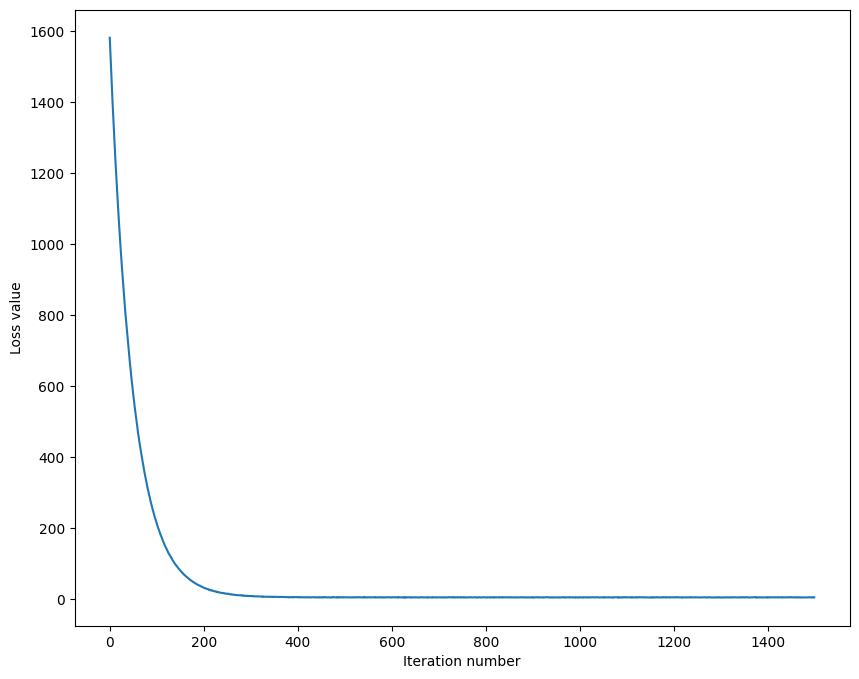

training accuracy: 0.354673
validation accuracy: 0.368000


In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7,
                      reg=5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
# The LinearSVM object that achieved the highest validation rate.
best_svm = None

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.geomspace(2e-7, 3e-7, 5)
regularization_strengths = np.geomspace(5e3, 5e4, 5)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create SVM and train it
    svm = LinearSVM()
    svm.train(X_train, y_train, lr, reg, num_iters=1000)

    # Compute training and validation sets accuracies and append to the dictionary
    y_train_pred, y_val_pred = svm.predict(X_train), svm.predict(X_val)
    results[(lr, reg)] = np.mean(
        y_train == y_train_pred), np.mean(y_val == y_val_pred)

    # Save if validation accuracy is the best
    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.377347 val accuracy: 0.381000
lr 2.000000e-07 reg 8.891397e+03 train accuracy: 0.378224 val accuracy: 0.383000
lr 2.000000e-07 reg 1.581139e+04 train accuracy: 0.369796 val accuracy: 0.363000
lr 2.000000e-07 reg 2.811707e+04 train accuracy: 0.362469 val accuracy: 0.375000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.348122 val accuracy: 0.359000
lr 2.213364e-07 reg 5.000000e+03 train accuracy: 0.379673 val accuracy: 0.367000
lr 2.213364e-07 reg 8.891397e+03 train accuracy: 0.383224 val accuracy: 0.409000
lr 2.213364e-07 reg 1.581139e+04 train accuracy: 0.360204 val accuracy: 0.390000
lr 2.213364e-07 reg 2.811707e+04 train accuracy: 0.355469 val accuracy: 0.382000
lr 2.213364e-07 reg 5.000000e+04 train accuracy: 0.347755 val accuracy: 0.358000
lr 2.449490e-07 reg 5.000000e+03 train accuracy: 0.385980 val accuracy: 0.372000
lr 2.449490e-07 reg 8.891397e+03 train accuracy: 0.380367 val accuracy: 0.378000
lr 2.449490e-07 reg 1.581139

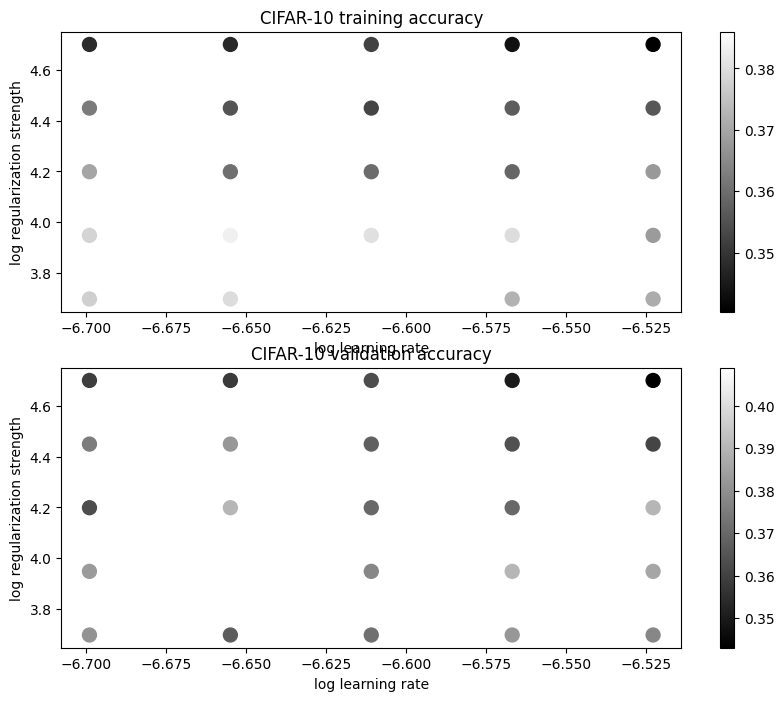

linear SVM on raw pixels final test set accuracy: 0.380000


In [ ]:
# Visualize the cross-validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results]  # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

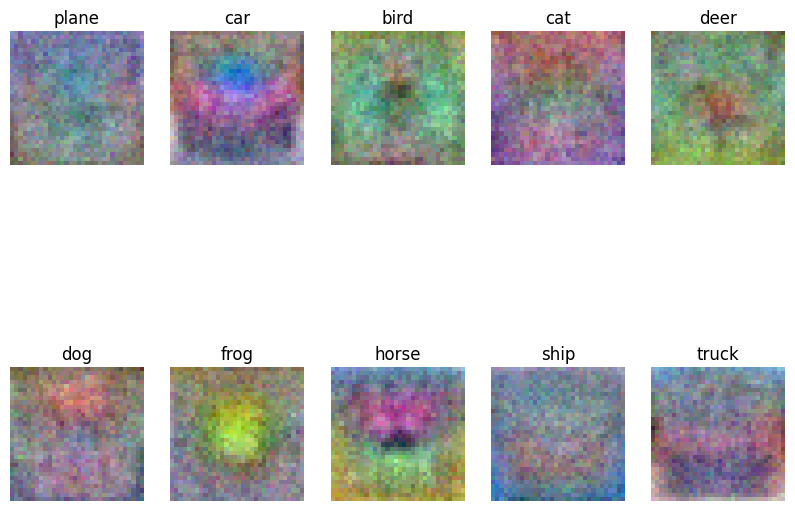

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1, :]  # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
